# Exploratory Data Analysis 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import math as math

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and Process the Data (same as Gen)

In [2]:
## US Data ##

data = pd.read_csv("../data/covid_data.csv", dtype = str)

#Data types
data['date'] = pd.to_datetime(data['date'])
data['lat'] = pd.to_numeric(data['lat'])
data['long_'] = pd.to_numeric(data['long_'])
data['confirmed'] = pd.to_numeric(data['confirmed'])
data['deaths'] = pd.to_numeric(data['deaths'])

## Global Data ##
data_global = pd.read_csv("../data/covid_data_global.csv", dtype = str)

#Data types
data_global['date'] = pd.to_datetime(data_global['date'])
data_global['lat'] = pd.to_numeric(data_global['lat'])
data_global['long'] = pd.to_numeric(data_global['long'])
data_global['confirmed'] = pd.to_numeric(data_global['confirmed'])
data_global['deaths'] = pd.to_numeric(data_global['deaths'])

### Calculate Incident Cases (same as Gen)

In [3]:
#US
data = data.sort_values(by = ['fips','date'])
data['prev_confirmed'] = data['confirmed'].shift(1) * \
    (data['fips'].fillna('') == \
     data['fips'].shift(1).fillna(''))
data['incident_cases'] = data.confirmed - data.prev_confirmed

#Global
data_global = data_global.sort_values(by = ['country_region','province_state','date'])
data_global['prev_confirmed'] = data_global['confirmed'].shift(1) * \
    (data_global['province_state'].fillna('') + data_global['country_region'].fillna('') == \
     data_global['province_state'].shift(1).fillna('') + data_global['country_region'].shift(1).fillna(''))
data_global['incident_cases'] = data_global.confirmed - data_global.prev_confirmed



In [4]:
#Subset to data on China only
china = data_global[data_global.country_region == 'China']

In [5]:
#US data only
data.head()

uid iso2 iso3 code3   fips county province_state country_region  \
321    84010001   US  USA   840  10001   Kent       Delaware             US   
3574   84010001   US  USA   840  10001   Kent       Delaware             US   
6827   84010001   US  USA   840  10001   Kent       Delaware             US   
10080  84010001   US  USA   840  10001   Kent       Delaware             US   
13333  84010001   US  USA   840  10001   Kent       Delaware             US   

             lat      long_        combined_key  confirmed  deaths       date  \
321    39.086466 -75.568849  Kent, Delaware, US          0       0 2020-01-22   
3574   39.086466 -75.568849  Kent, Delaware, US          0       0 2020-01-23   
6827   39.086466 -75.568849  Kent, Delaware, US          0       0 2020-01-24   
10080  39.086466 -75.568849  Kent, Delaware, US          0       0 2020-01-25   
13333  39.086466 -75.568849  Kent, Delaware, US          0       0 2020-01-26   

       prev_confirmed  incident_cases  
321               NaN             NaN  
3574              0.0             0.0  
6827              0.0             0.0  
10080             0.0             0.0  
13333             0.0             0.0

In [6]:
#Remove territories for mapping purposes
non_states = ['American Samoa','Diamond Princess', 'Grand Princess','Guam','Northern Mariana Islands', 'Puerto Rico'\
             , 'Virgin Islands']
data = data[~data['province_state'].isin(non_states)]

In [7]:
#Groupby to get daily totals
daily_total = data.groupby(['date','province_state'], as_index = False).sum()

In [8]:
#Load in shapefile of the US states
#from https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj
usa = gpd.read_file('../data/States_21basic/geo_export_d7c791c0-6990-477e-9d1c-462fd3ff41b3.shp')

In [9]:
usa.head()

drawseq state_abbr state_fips    state_name          sub_region  \
0      NaN         HI         15        Hawaii             Pacific   
1      NaN         WA         53    Washington             Pacific   
2      NaN         MT         30       Montana            Mountain   
3      NaN         ME         23         Maine         New England   
4      NaN         ND         38  North Dakota  West North Central   

                                            geometry  
0  MULTIPOLYGON (((-160.07380 22.00418, -160.0497...  
1  MULTIPOLYGON (((-122.40202 48.22522, -122.4628...  
2  POLYGON ((-111.47543 44.70216, -111.48080 44.6...  
3  MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...  
4  POLYGON ((-98.73044 45.93827, -99.00683 45.939...

In [10]:
shape_data = usa.merge(daily_total, left_on = 'state_name', right_on = 'province_state')

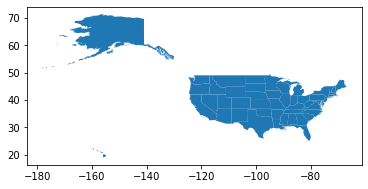

In [11]:
shape_data[shape_data.date == '2020-01-22'].plot()

In [12]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

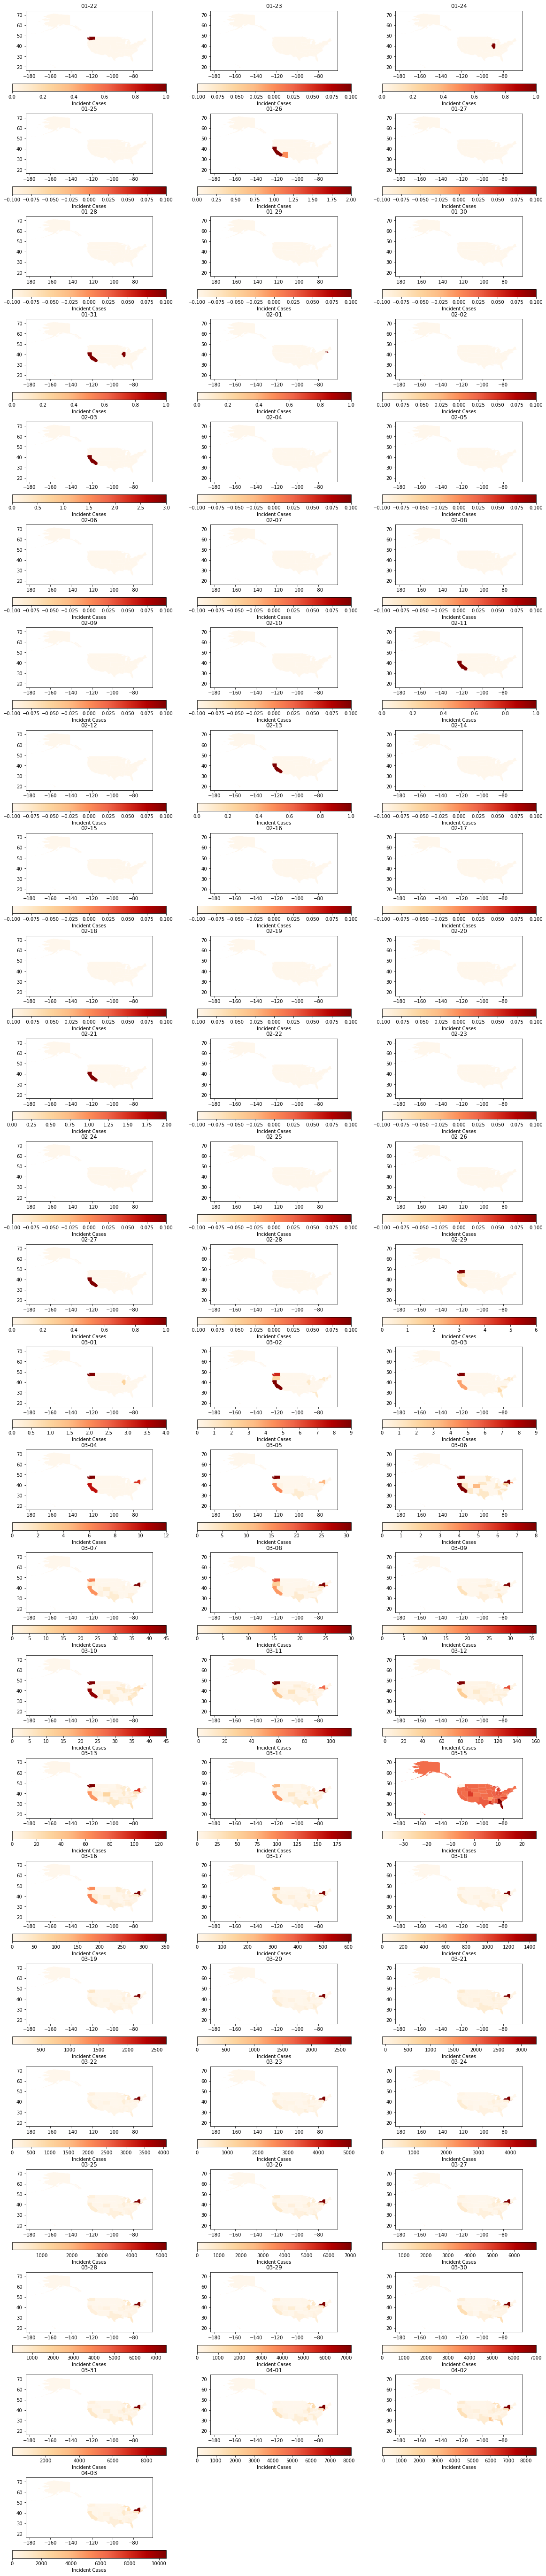

In [13]:
#use conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data
    
num_days = len(shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in shape_data.date.unique():
    shape_data[shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          legend_kwds={'label': "Incident Cases",
                                                       'orientation': "horizontal"})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1



On these maps is it essential to look at the scale! We see an interesting occurance on March 15th, and afterward see New York begin to stunt the levels of incident cases in all other states. 

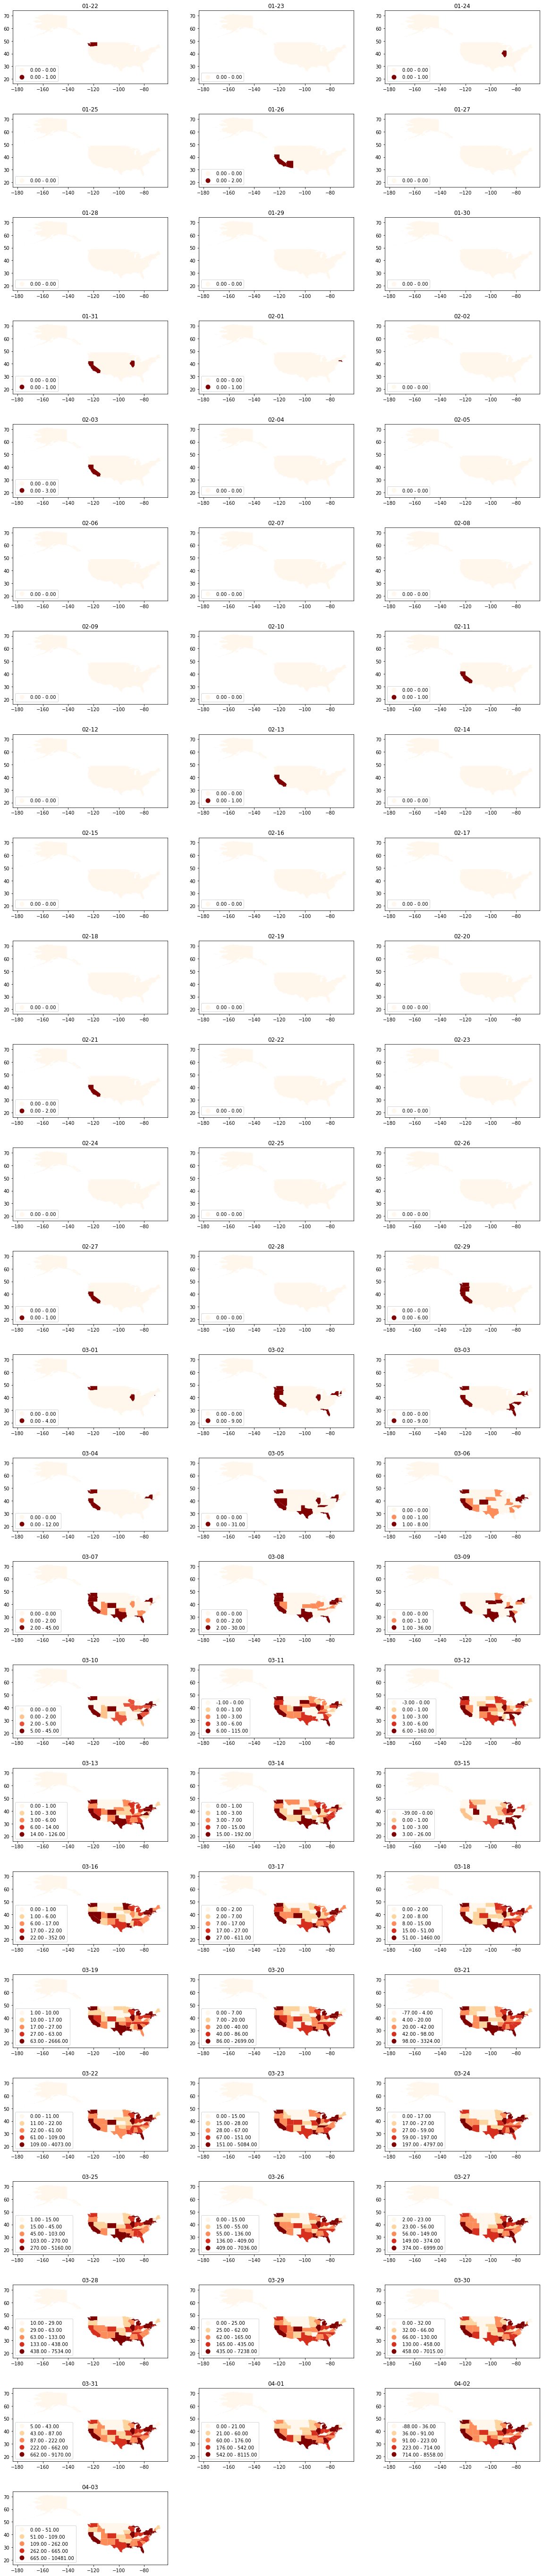

In [14]:
#to be able to use scheme = "quantiles"
#use - conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data

num_days = len(shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in shape_data.date.unique():
    shape_data[shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          scheme="quantiles",
                                        legend_kwds={'loc': 'lower left'})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1


These maps by quantile give us better perspecitve of categorizing states based on their number of indicent cases relative to others. With quantiles we do not have the issue of epicenters like New York preventing us from seeing information about all other states. Additionally, on March 15th (note how it looked in the previous graphs), we can now see differentiation. 

In [15]:
#Load in shapefile of the US counties
#from https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj
china_shapes = gpd.read_file('../data/chn_admbnda_adm1_ocha/chn_admbnda_adm1_ocha.shp')

In [16]:
china_shapes.head()

ADM1_EN ADM1_ZH ADM1_PCODE ADM0_EN ADM0_ZH ADM0_PCODE  \
0          Anhui Province     安徽省      CN340   China      中国         CN   
1          Anhui Province     安徽省      CN341   China      中国         CN   
2    Beijing Municipality     北京市      CN110   China      中国         CN   
3  Chongqing Municipality     重庆市      CN500   China      中国         CN   
4         Fujian Province     福建省      CN350   China      中国         CN   

                                            geometry  
0  POLYGON ((116.93521 34.08702, 116.94069 34.086...  
1  MULTIPOLYGON (((118.34087 31.95368, 118.33095 ...  
2  POLYGON ((117.31471 40.18092, 117.31990 40.173...  
3  POLYGON ((109.54600 31.72161, 109.56352 31.718...  
4  MULTIPOLYGON (((117.23266 23.63400, 117.22842 ...

In [17]:
#formatting to ensure that the province names are the same
china_shapes['ADM1_EN'] = china_shapes['ADM1_EN'].str.split(' ').str[0]

In [18]:
china_shapes.ADM1_EN.unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong', 'Hubei', 'Hunan', 'Inner', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macao', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Taiwan', 'Tianjin', 'Tibet',
       'Xinjiang', 'Yunnan', 'Zhejiang'], dtype=object)

In [19]:
china['province_state'] = china['province_state'].str.split(' ').str[0]

In [20]:
china.province_state = china.province_state.replace('Macau', 'Macao')

In [21]:
china_shapes.drop(china_shapes[china_shapes.ADM1_EN == 'Taiwan'].index, inplace=True)

In [22]:
china_shapes.ADM1_EN.unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong', 'Hubei', 'Hunan', 'Inner', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macao', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang'], dtype=object)

In [23]:
china.province_state.unique()

array(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong', 'Hubei', 'Hunan', 'Inner', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macao', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang'], dtype=object)

In [24]:
#same methodology as with the US - groupby to get daily totals
daily_china_total = china.groupby(['date','province_state'], as_index = False).sum()

In [25]:
#merge in the geospatial data on province name
china_shape_data = china_shapes.merge(daily_china_total, left_on = 'ADM1_EN', right_on = 'province_state')

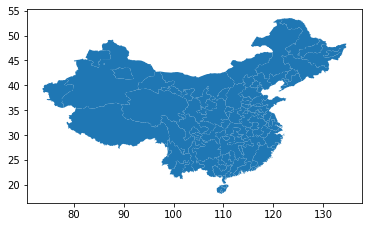

In [26]:
#plot one map to see how it looks
china_shape_data[china_shape_data.date == '2020-01-22'].plot()

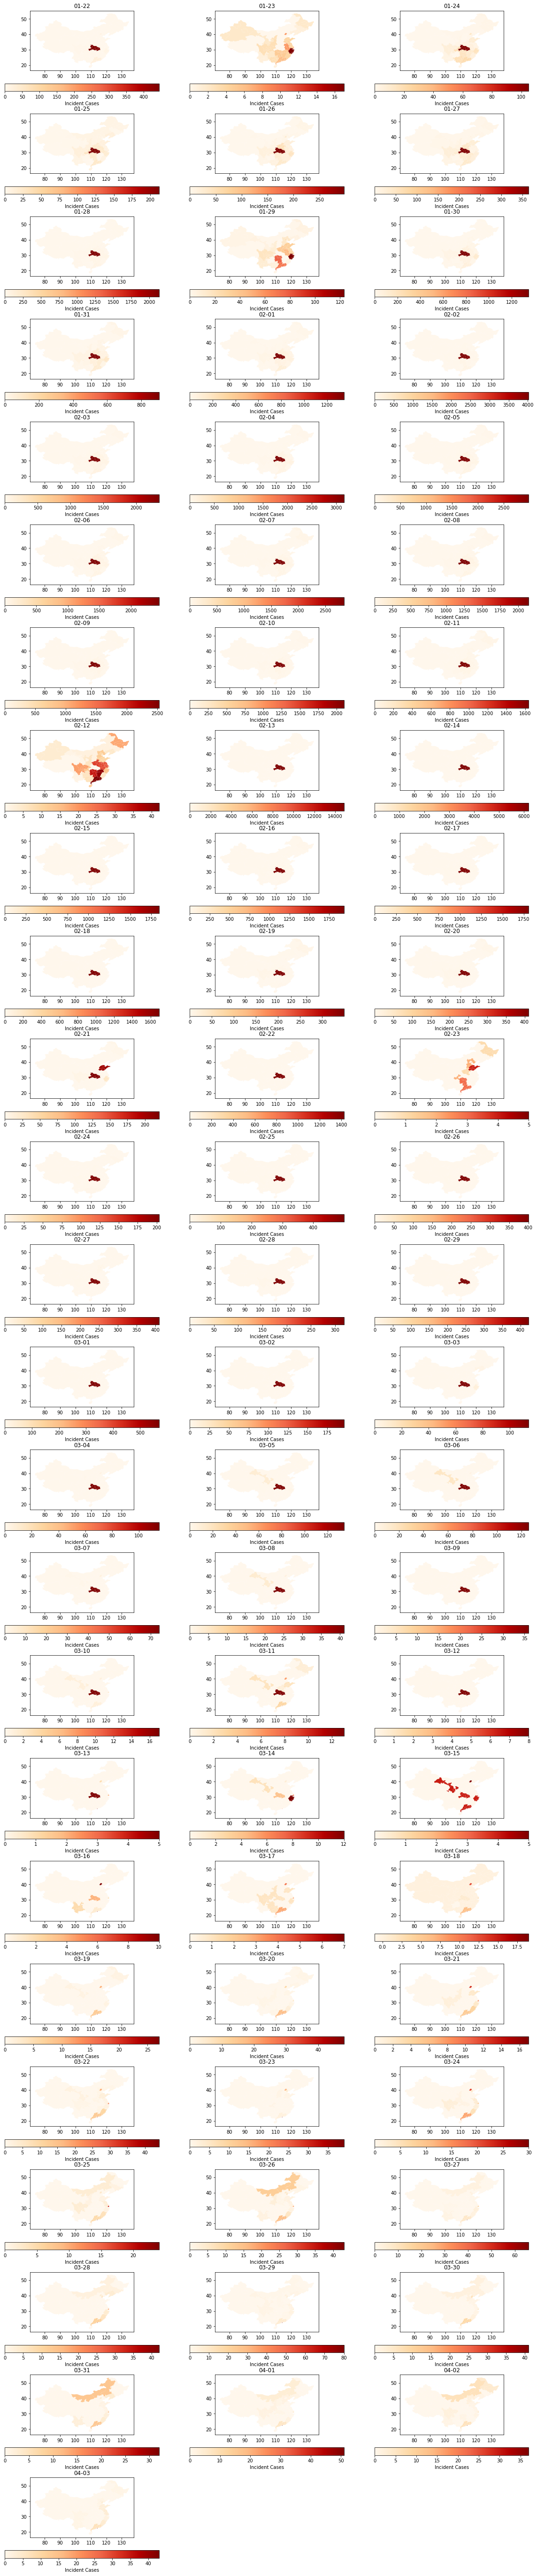

In [27]:
#use conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data
    
num_days = len(china_shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in china_shape_data.date.unique():
    china_shape_data[china_shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          legend_kwds={'label': "Incident Cases",
                                                       'orientation': "horizontal"})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1



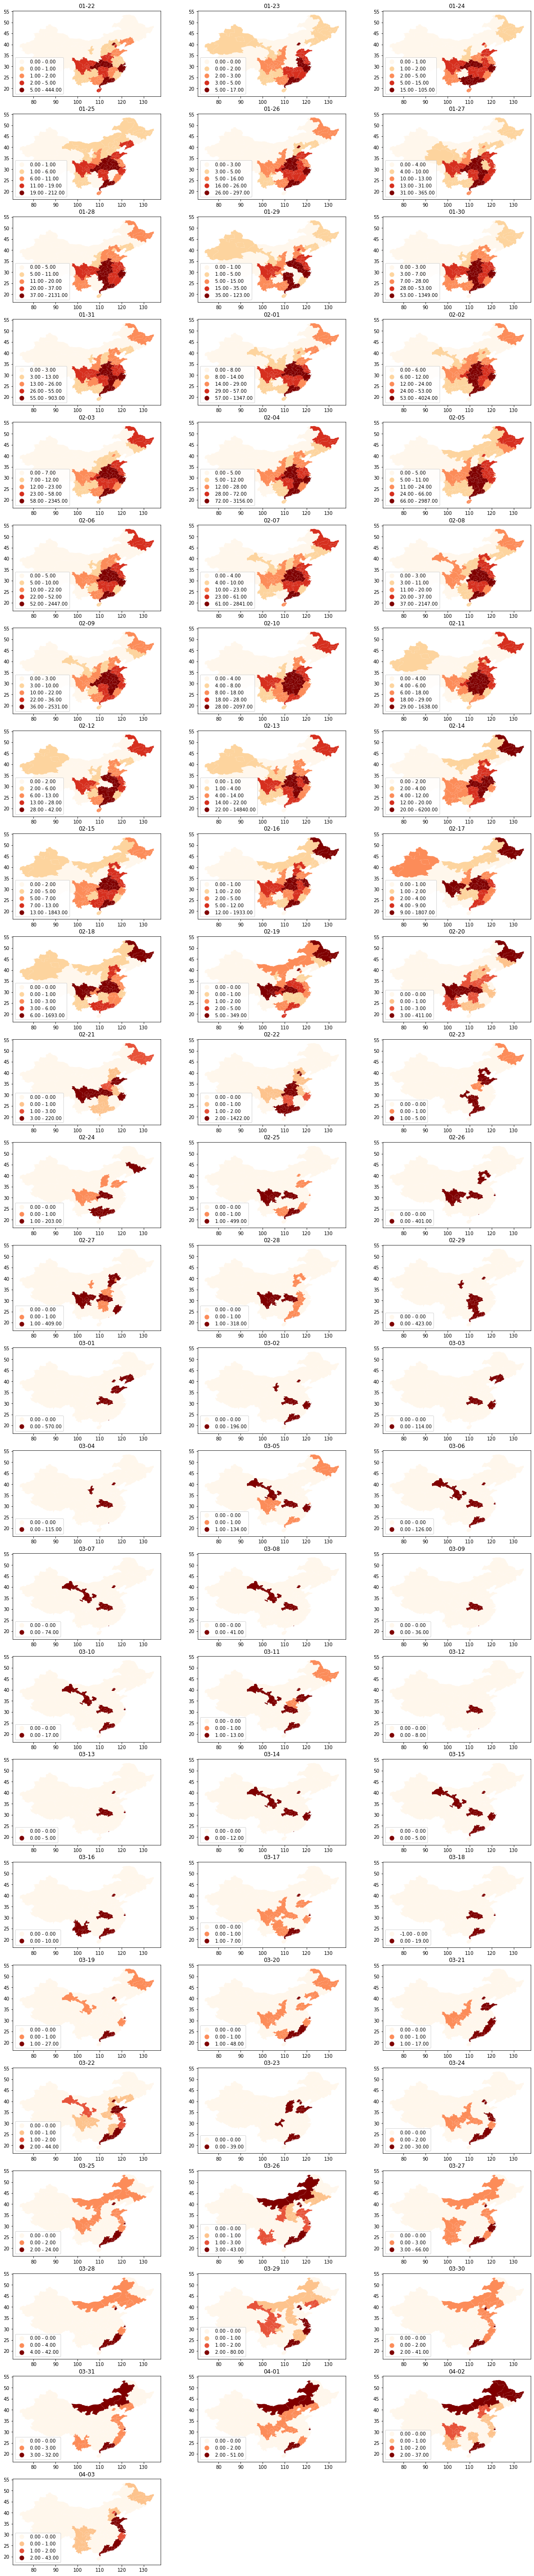

In [28]:
#to be able to use scheme = "quantiles"
#use - conda install -c conda-forge mapclassify

#getting the number of days as this will change with our
#daily updating data

num_days = len(china_shape_data.date.unique())

fig, axs = plt.subplots(math.ceil(num_days/3), 3, figsize = (20,100))

#Delete excess plots depending on how many days we are looking at
if np.mod(num_days, 3) == 2:
    fig.delaxes(axs[24][2])
elif np.mod(num_days, 3) == 1:
    fig.delaxes(axs[24][2])
    fig.delaxes(axs[24][1])


num= 0
num2= 0
for i in china_shape_data.date.unique():
    china_shape_data[china_shape_data.date == i].plot(column = 'incident_cases', cmap='OrRd',\
                                          legend = True,
                                          ax=axs[num][num2],
                                          scheme="quantiles",
                                        legend_kwds={'loc': 'lower left'})
    axs[num][num2].set_title(i.astype('str')[5:10])
    
    num2+=1
    
    #go to the next row
    if num2 == 3:
        num2 =0
        num+=1


We can see the spread from Wuhan in these maps!